In [2]:
import os
import pandas as pd
import tensorflow as tf

import os
import sys
parent_dir = os.path.dirname(os.getcwd())
grandparent_dir = os.path.dirname(parent_dir)
sys.path.append(parent_dir)
utils_dir = os.path.join(parent_dir, grandparent_dir, "src", "utils")
sys.path.append(utils_dir)

from weighted_accuracy_and_tools import decompose_y, reconstruct_y, weighted_accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score

import pandas as pd

In [3]:
# Add the path to the data trainXNGOI6467.csv
X_path= os.path.join("..", "..", "data","original_input", "X_train_spot_predict_with_decision_tree.csv")
X = pd.read_csv(X_path, delimiter=',')

y_path= os.path.join("..","..", "data","original_input", "y_train_jJtXgMX.csv")
y = pd.read_csv(y_path, delimiter=',')

In [4]:
X.set_index("DELIVERY_START", inplace=True)
y.set_index("DELIVERY_START", inplace=True)
X.index = pd.to_datetime(X.index, utc=True)
y.index = pd.to_datetime(y.index, utc=True)
X.shape

(10605, 11)

In [5]:
# count the number of missing values in X for each column (nan values)
X.isna().sum()

load_forecast                      0
coal_power_available               0
gas_power_available                0
nucelear_power_available           0
wind_power_forecasts_average       0
solar_power_forecasts_average      0
wind_power_forecasts_std           0
solar_power_forecasts_std          0
predicted_spot_price             240
month                              0
year                               0
dtype: int64

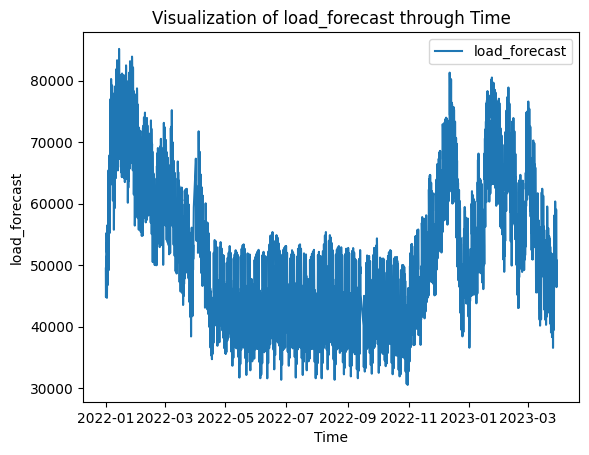

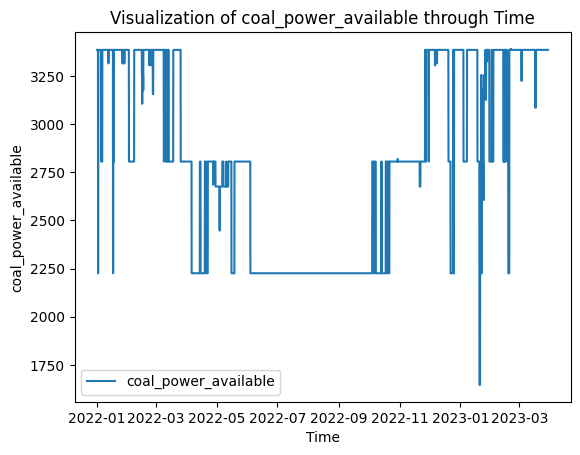

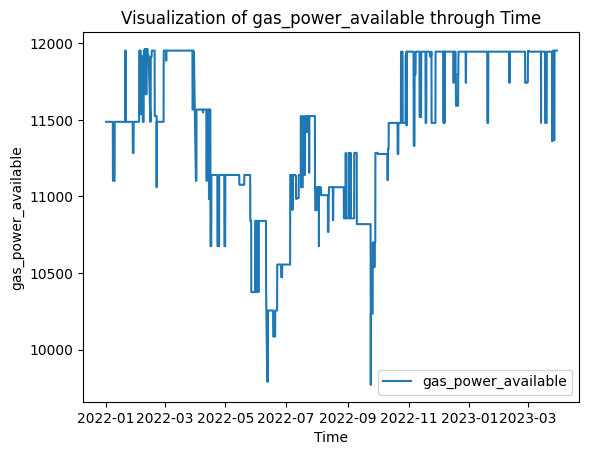

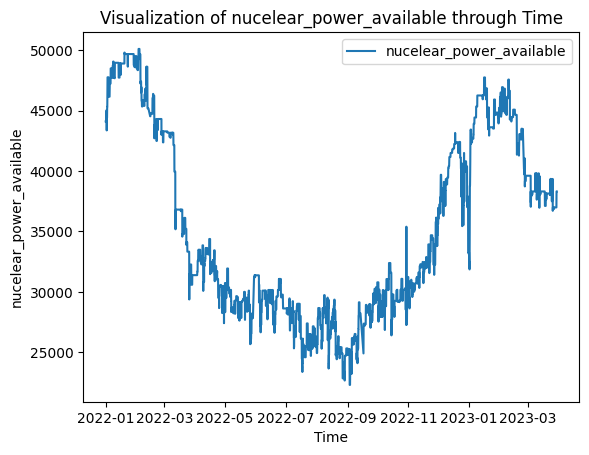

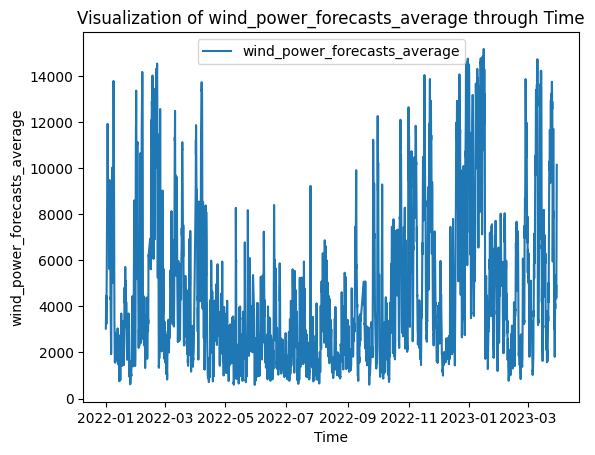

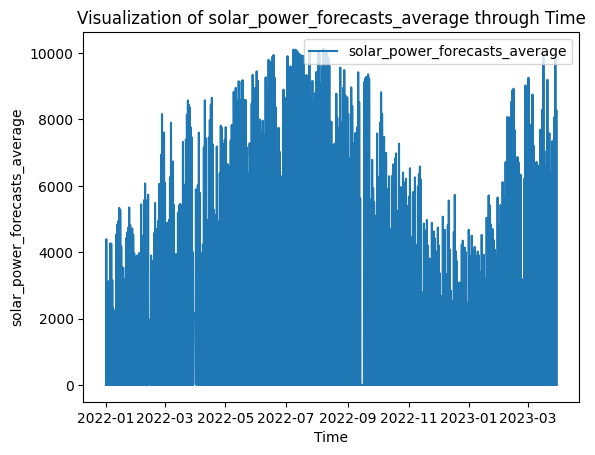

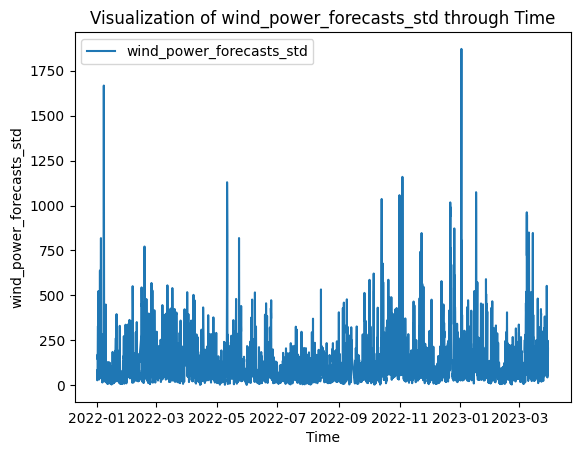

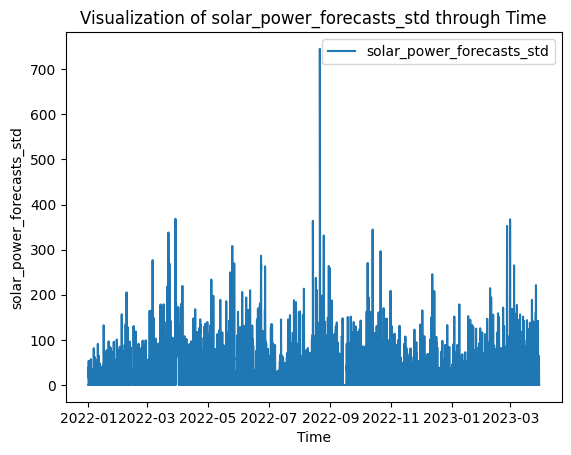

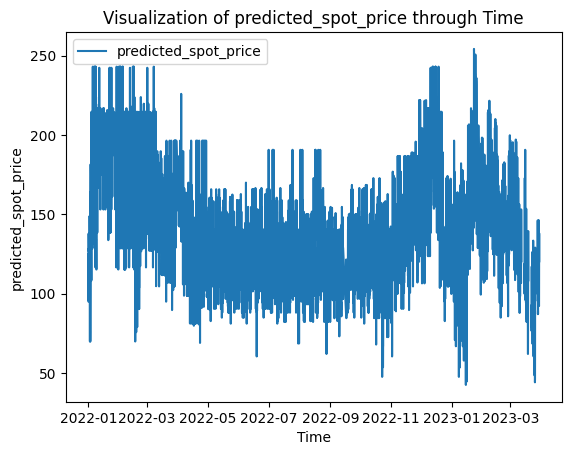

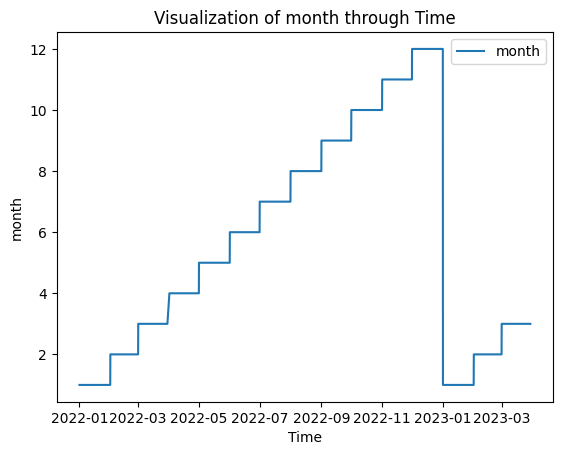

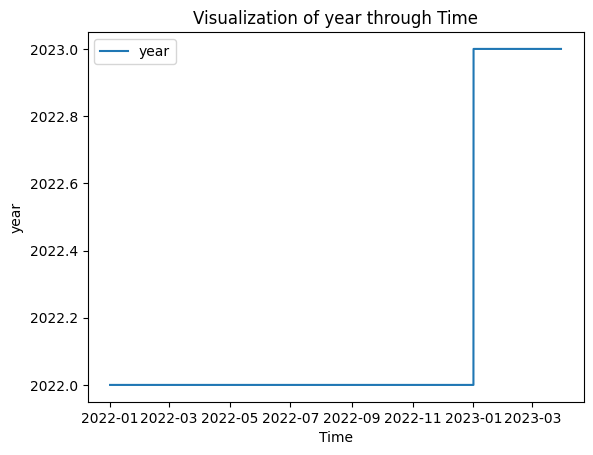

In [6]:
import matplotlib.pyplot as plt
# Iterate over each column in the dataframe
for column in X.columns:
    # Create a line plot for the column
    plt.plot(X.index, X[column], label=column)

    # Set the x-axis label
    plt.xlabel('Time')

    # Set the y-axis label
    plt.ylabel(str(column))

    # Set the title of the plot
    plt.title("Visualization of "+str(column)+" through Time")

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()


In [7]:
X['predicted_spot_price'] = X['predicted_spot_price'].fillna(
    X['predicted_spot_price'].rolling(window=3, min_periods=1, center=True).mean()
)

# Check if there are still NaNs left and use forward fill to handle any remaining ones
X['predicted_spot_price'] = X['predicted_spot_price'].fillna(method='ffill')

# If there are still NaNs at the beginning, use backward fill as a last resort
X['predicted_spot_price'] = X['predicted_spot_price'].fillna(method='bfill')

In [8]:
X.isna().sum()

load_forecast                    0
coal_power_available             0
gas_power_available              0
nucelear_power_available         0
wind_power_forecasts_average     0
solar_power_forecasts_average    0
wind_power_forecasts_std         0
solar_power_forecasts_std        0
predicted_spot_price             0
month                            0
year                             0
dtype: int64

In [9]:
y_direction, y_magnitude = decompose_y(y['spot_id_delta'])
X_train_direction, X_test_direction, y_train_direction, y_test_direction = train_test_split(X, y_direction, test_size=0.2, random_state=42)
X_train_magnitude, X_test_magnitude, y_train_magnitude, y_test_magnitude = train_test_split(X, y_magnitude, test_size=0.2, random_state=42)

In [10]:
y_direction

DELIVERY_START
2022-01-01 01:00:00+00:00    0
2022-01-01 02:00:00+00:00    0
2022-01-01 03:00:00+00:00    0
2022-01-01 04:00:00+00:00    1
2022-01-01 05:00:00+00:00    1
                            ..
2023-03-29 17:00:00+00:00    1
2023-03-29 18:00:00+00:00    1
2023-03-29 19:00:00+00:00    1
2023-03-29 20:00:00+00:00    1
2023-03-29 21:00:00+00:00    1
Name: spot_id_delta, Length: 10605, dtype: int32

In [11]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

# Assuming X and y_magnitude are already defined and properly preprocessed

input_dim = X.shape[1]

# Define the model architecture for regression
model_relu_regression = Sequential([
    Dense(32, activation='relu', input_shape=(input_dim,)),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(32, activation='relu'),
    Dense(1)  # No activation function is needed in the output layer for regression
])

lr = 0.00001  # Smaller learning rate
batch_size = 256
optimizer = Adam(learning_rate=lr)

# Compile the model
model_relu_regression.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])

# Path to save the model
model_path_relu_regression = os.path.join("models", 'relu_regression_model.h5')

# Callbacks
checkpoint_callback_relu_regression = ModelCheckpoint(model_path_relu_regression, save_best_only=True, save_freq='epoch', period=5, verbose=1)
early_stopping_callback_relu_regression = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

# Check if a pre-trained model exists
if os.path.exists(model_path_relu_regression):
    print("Loading existing model...")
    model_relu_regression = tf.keras.models.load_model(model_path_relu_regression)

# Train the model
history_relu_regression = model_relu_regression.fit(
    X, y_magnitude, 
    epochs=100,  # Training for 100 epochs as previously discussed for consistency
    batch_size=batch_size, 
    validation_split=0.2,  # Assuming you have enough data to split off 20% for validation
    callbacks=[checkpoint_callback_relu_regression, early_stopping_callback_relu_regression]
)

# Optionally, you can save the final model state if required (model might already be saved by checkpoint)
model_relu_regression.save(model_path_relu_regression)


Loading existing model...
Epoch 1/100
34/34 [==============================] - 1s 9ms/step - loss: 1235.5416 - mse: 1235.5416 - val_loss: 175.9588 - val_mse: 175.9588
Epoch 2/100
34/34 [==============================] - 0s 3ms/step - loss: 1235.4714 - mse: 1235.4714 - val_loss: 175.9231 - val_mse: 175.9231
Epoch 3/100
34/34 [==============================] - 0s 5ms/step - loss: 1234.7714 - mse: 1234.7714 - val_loss: 176.0096 - val_mse: 176.0096
Epoch 4/100
34/34 [==============================] - 0s 3ms/step - loss: 1235.2749 - mse: 1235.2749 - val_loss: 176.0433 - val_mse: 176.0433
Epoch 5/100
24/34 [====================>.........] - ETA: 0s - loss: 1043.4093 - mse: 1043.4093
Epoch 5: val_loss improved from inf to 175.95430, saving model to models\regression_model.h5
34/34 [==============================] - 0s 5ms/step - loss: 1234.7080 - mse: 1234.7080 - val_loss: 175.9543 - val_mse: 175.9543
Epoch 6/100
34/34 [==============================] - 0s 3ms/step - loss: 1233.3997 - mse: 12

c:\Users\emac\Documents\MachineLearningAvance\elmy\elmy\venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/34 [==============================] - 0s 3ms/step - loss: 1232.9557 - mse: 1232.9557 - val_loss: 175.8768 - val_mse: 175.8768
Epoch 8/100
34/34 [==============================] - 0s 3ms/step - loss: 1232.8799 - mse: 1232.8799 - val_loss: 175.8216 - val_mse: 175.8216
Epoch 9/100
34/34 [==============================] - 0s 3ms/step - loss: 1232.6526 - mse: 1232.6526 - val_loss: 175.8322 - val_mse: 175.8322
Epoch 10/100
30/34 [=========================>....] - ETA: 0s - loss: 1282.1306 - mse: 1282.1306
Epoch 10: val_loss improved from 175.95430 to 175.84947, saving model to models\regression_model.h5
34/34 [==============================] - 0s 4ms/step - loss: 1232.9065 - mse: 1232.9065 - val_loss: 175.8495 - val_mse: 175.8495
Epoch 11/100
34/34 [==============================] - 0s 3ms/step - loss: 1233.4185 - mse: 1233.4185 - val_loss: 175.8746 - val_mse: 175.8746
Epoch 12/100
34/34 [==============================] - 0s 3ms/step - loss: 1231.5531 - mse: 1231.5531 - val_loss: 175.7656

In [12]:
# val loss 241, val mse 241
# val loss 199, val mse 199
# val loss 178.8, val mse 178.8
# val loss 175.9, val mse 175.9

In [13]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

# Assuming X and y_direction are already defined and properly preprocessed

input_dim = X.shape[1]

# Define the model architecture
model_classification = Sequential([
    Dense(32, activation='relu', input_shape=(input_dim,)),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

lr = 0.00001  # Smaller learning rate
batch_size = 256 
optimizer = Adam(learning_rate=lr)
# Compile the model
model_classification.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Path to save the model
model_path = os.path.join("models", 'classification_model.h5')

# Callbacks
checkpoint_callback = ModelCheckpoint(model_path, save_best_only=True, save_freq='epoch', period=5, verbose=1)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

# Check if a pre-trained model exists
if os.path.exists(model_path):
    print("Loading existing model...")
    model_classification = tf.keras.models.load_model(model_path)

# Train the model
history = model_classification.fit(
    X, y_direction, 
    epochs=100, 
    batch_size=batch_size, 
    validation_split=0.2,  # Assuming you have enough data to split off 20% for validation
    callbacks=[checkpoint_callback, early_stopping_callback]
)

# Optionally, you can save the final model state if required (model might already be saved by checkpoint)
model_classification.save(model_path)


Loading existing model...
Epoch 1/100
34/34 [==============================] - 1s 10ms/step - loss: 0.6804 - accuracy: 0.5685 - val_loss: 0.7081 - val_accuracy: 0.4861
Epoch 2/100
34/34 [==============================] - 0s 3ms/step - loss: 0.6799 - accuracy: 0.5655 - val_loss: 0.7088 - val_accuracy: 0.4828
Epoch 3/100
34/34 [==============================] - 0s 3ms/step - loss: 0.6798 - accuracy: 0.5661 - val_loss: 0.7082 - val_accuracy: 0.4866
Epoch 4/100
34/34 [==============================] - 0s 3ms/step - loss: 0.6793 - accuracy: 0.5687 - val_loss: 0.7085 - val_accuracy: 0.4851
Epoch 5/100
25/34 [=====================>........] - ETA: 0s - loss: 0.6802 - accuracy: 0.5719
Epoch 5: val_loss improved from inf to 0.70796, saving model to models\classification_model.h5
34/34 [==============================] - 0s 4ms/step - loss: 0.6810 - accuracy: 0.5662 - val_loss: 0.7080 - val_accuracy: 0.4880
Epoch 6/100
34/34 [==============================] - 0s 5ms/step - loss: 0.6799 - accuracy

c:\Users\emac\Documents\MachineLearningAvance\elmy\elmy\venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 7/100
34/34 [==============================] - 0s 4ms/step - loss: 0.6789 - accuracy: 0.5660 - val_loss: 0.7078 - val_accuracy: 0.4922
Epoch 8/100
34/34 [==============================] - 0s 4ms/step - loss: 0.6790 - accuracy: 0.5688 - val_loss: 0.7078 - val_accuracy: 0.4913
Epoch 9/100
34/34 [==============================] - 0s 4ms/step - loss: 0.6804 - accuracy: 0.5679 - val_loss: 0.7069 - val_accuracy: 0.4932
Epoch 10/100
21/34 [=================>............] - ETA: 0s - loss: 0.6790 - accuracy: 0.5718
Epoch 10: val_loss improved from 0.70796 to 0.70743, saving model to models\classification_model.h5
34/34 [==============================] - 0s 6ms/step - loss: 0.6784 - accuracy: 0.5719 - val_loss: 0.7074 - val_accuracy: 0.4922
Epoch 11/100
34/34 [==============================] - 0s 3ms/step - loss: 0.6791 - accuracy: 0.5674 - val_loss: 0.7079 - val_accuracy: 0.4908
Epoch 12/100
34/34 [==============================] - 0s 3ms/step - loss: 0.6791 - accuracy: 0.5721 - val_loss

In [14]:
# val loss 0.71, val accuracy 0.48

In [15]:
X_test_path= os.path.join("..", "..", "data","original_input", "X_test_GgyECq8.csv")
X_test = pd.read_csv(X_test_path, delimiter=',')
delivery_start = X_test["DELIVERY_START"]

In [16]:
X_test.set_index("DELIVERY_START", inplace=True)
X_test.index = pd.to_datetime(X_test.index, utc=True)

In [17]:
# Extract month and year from "DELIVERY_START" column
X_test['month'] = X_test.index.month
X_test['year'] = X_test.index.year
X_test.shape

(4942, 11)

In [18]:
nan_counts = X_test.isna().sum()
print(nan_counts)


load_forecast                       0
coal_power_available                0
gas_power_available                 0
nucelear_power_available            0
wind_power_forecasts_average        0
solar_power_forecasts_average      24
wind_power_forecasts_std            0
solar_power_forecasts_std          24
predicted_spot_price             1536
month                               0
year                                0
dtype: int64


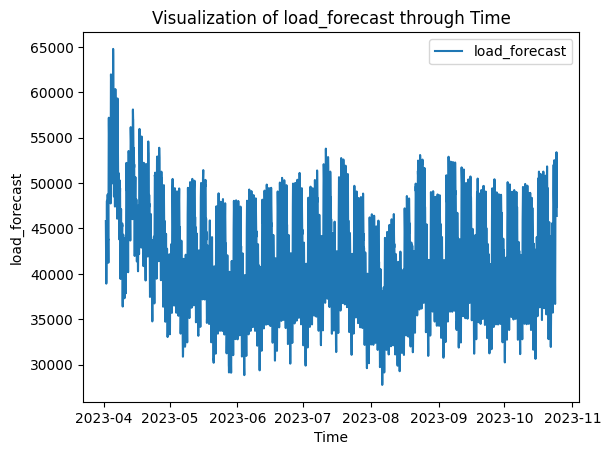

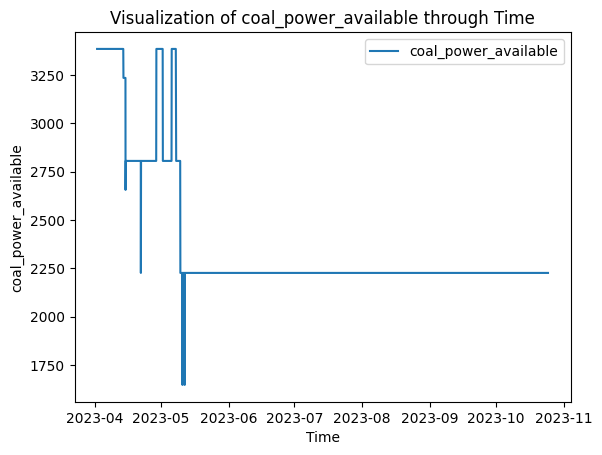

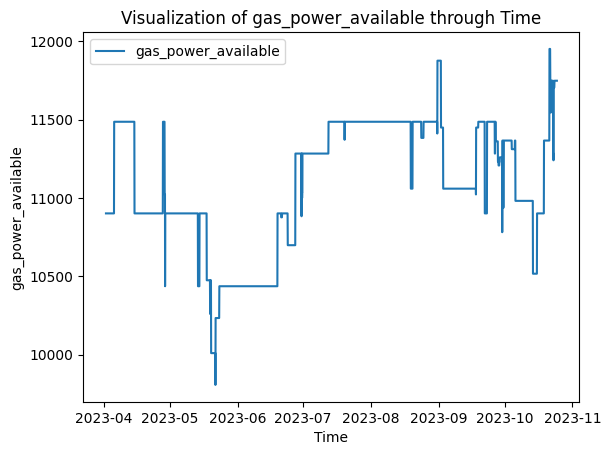

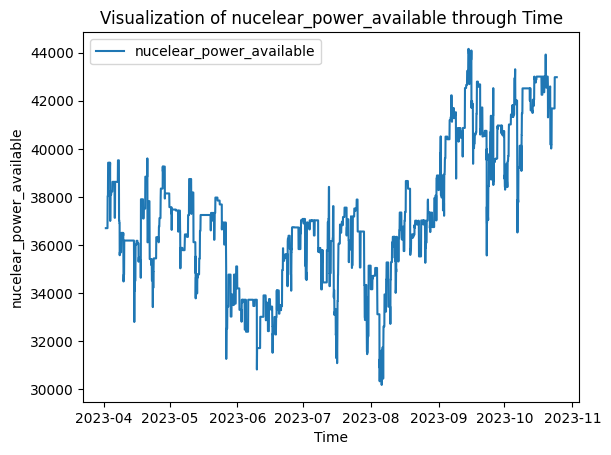

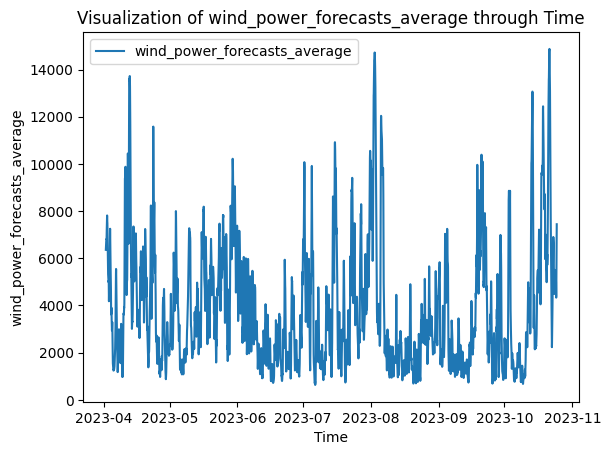

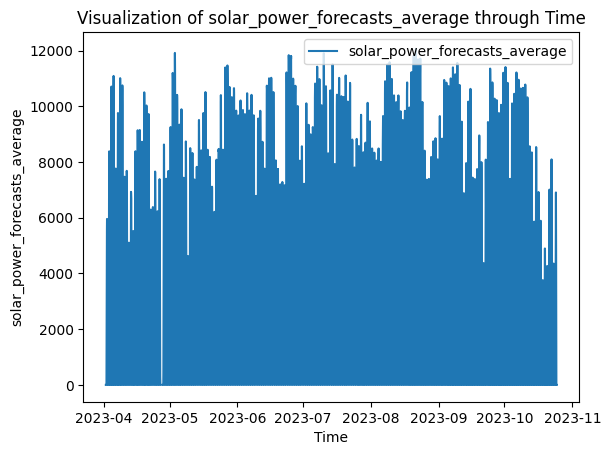

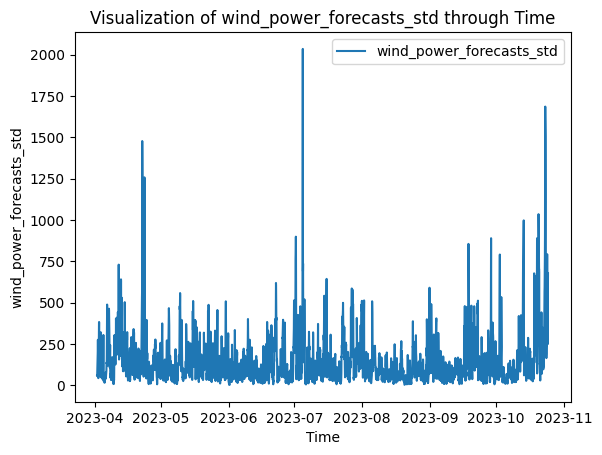

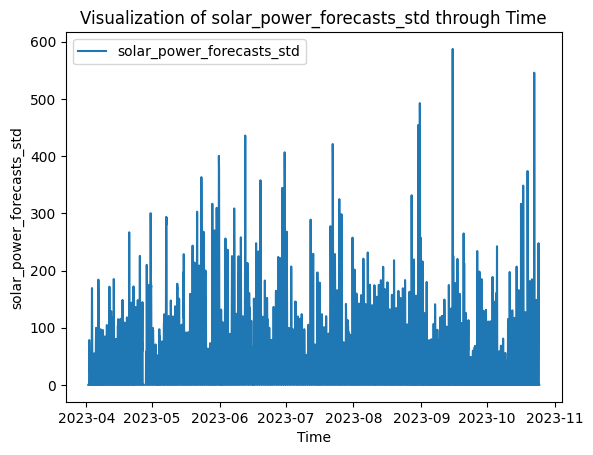

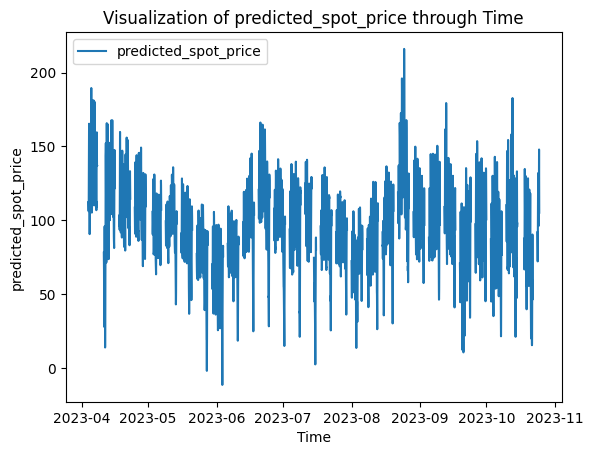

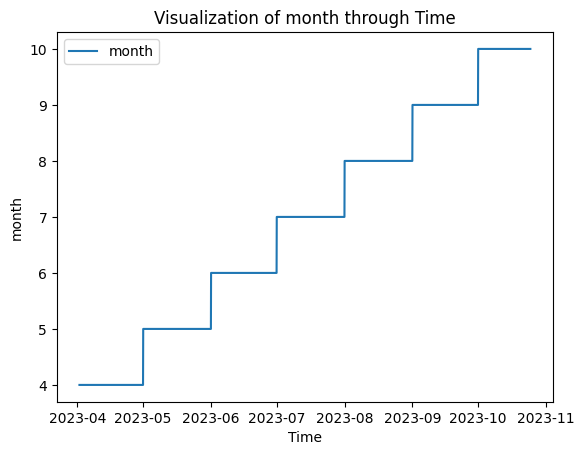

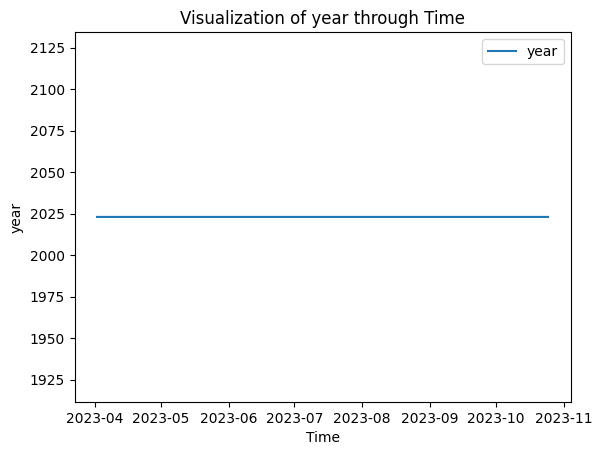

In [19]:
import matplotlib.pyplot as plt
# Iterate over each column in the dataframe
for column in X_test.columns:
    # Create a line plot for the column
    plt.plot(X_test.index, X_test[column], label=column)

    # Set the x-axis label
    plt.xlabel('Time')

    # Set the y-axis label
    plt.ylabel(str(column))

    # Set the title of the plot
    plt.title("Visualization of "+str(column)+" through Time")

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()


In [20]:
X_test = X_test.fillna(
    X_test.rolling(window=3, min_periods=1, center=True).mean()
)

# Check if there are still NaNs left and use forward fill to handle any remaining ones
X_test = X_test.fillna(method='ffill')

# If there are still NaNs at the beginning, use backward fill as a last resort
X_test = X_test.fillna(method='bfill')

In [21]:
nan_counts = X_test.isna().sum()
print(nan_counts)


load_forecast                    0
coal_power_available             0
gas_power_available              0
nucelear_power_available         0
wind_power_forecasts_average     0
solar_power_forecasts_average    0
wind_power_forecasts_std         0
solar_power_forecasts_std        0
predicted_spot_price             0
month                            0
year                             0
dtype: int64


In [22]:
import tensorflow as tf
from tensorflow import keras

# Load the classification model
classification_model = keras.models.load_model(os.path.join("models",'classification_model.h5'))

# Load the regression model
relu_regression_model = keras.models.load_model(os.path.join("models",'relu_regression_model.h5'))

# Make predictions on X_test
direction_predictions = classification_model.predict(X_test)
magnitude_predictions = relu_regression_model.predict(X_test)


155/155 [==============================] - 0s 967us/step


In [23]:
direction_predictions

array([[0.48578778],
       [0.46354386],
       [0.44768927],
       ...,
       [0.33293748],
       [0.31847465],
       [0.33133188]], dtype=float32)

In [24]:
over_005 = len(direction_predictions[direction_predictions > 0.25])
under_005 = len(direction_predictions[direction_predictions < 0.25])

print("Values over 0.25:", over_005)
print("Values under 0.25:", under_005)
direction_predictions[direction_predictions > 0.25] = 1
direction_predictions[direction_predictions <= 0.25] = 0


Values over 0.25: 3421
Values under 0.25: 1521


In [25]:
import numpy as np

count_1 = np.count_nonzero(direction_predictions == 1)
count_minus_1 = np.count_nonzero(direction_predictions == 0)

print("Number of 1:", count_1)
print("Number of -1:", count_minus_1)


Number of 1: 3421
Number of -1: 1521


In [26]:
magnitude_predictions

array([[4.286953 ],
       [3.9399338],
       [3.7539775],
       ...,
       [9.000716 ],
       [8.23591  ],
       [8.2258005]], dtype=float32)

In [27]:
y_pred = reconstruct_y(direction_predictions, magnitude_predictions)
d = {"DELIVERY_START" : delivery_start, "spot_id_delta" : y_pred.reshape(-1)}
y_pred = pd.DataFrame(data = d)


In [28]:
y_pred


,DELIVERY_START,spot_id_delta
0,2023-04-02 00:00:00+02:00,4.286953
1,2023-04-02 01:00:00+02:00,3.939934
2,2023-04-02 02:00:00+02:00,3.753978
3,2023-04-02 03:00:00+02:00,3.299692
4,2023-04-02 04:00:00+02:00,3.087562
...,...,...
4937,2023-10-24 19:00:00+02:00,8.566720
4938,2023-10-24 20:00:00+02:00,9.640509
4939,2023-10-24 21:00:00+02:00,9.000716
4940,2023-10-24 22:00:00+02:00,8.235910


In [31]:
mean_spot_id_delta = y['spot_id_delta'].mean()
mean_spot_id_delta_pred = y_pred['spot_id_delta'].mean()
print(mean_spot_id_delta, mean_spot_id_delta_pred)

0.9433581668879994 1.6567152


In [30]:
y_pred.to_csv("output/y_result_nn1.csv", index = False)

In [44]:
from sklearn.model_selection import train_test_split

X_train, X_test_validation, y_train, y_test_validation = train_test_split(X, y, train_size=0.6, random_state=42)
X_test, X_validation, y_test, y_validation = train_test_split(X_test_validation, y_test_validation, train_size=0.5, random_state=42)

In [39]:
y_train.shape, y_test.shape, y_validation.shape

((6363, 1), (2121, 1), (2121, 1))

In [ ]:
"""import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

# Assuming X and y_direction are already defined and properly preprocessed

input_dim = X.shape[1]

# Define the model architecture
model_classification = Sequential([
    Dense(32, activation='relu', input_shape=(input_dim,)),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

lr = 0.00001  # Smaller learning rate
batch_size = 256 
optimizer = Adam(learning_rate=lr)
# Compile the model
model_classification.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Path to save the model
model_path = os.path.join("models", 'classification_model.h5')

# Callbacks
checkpoint_callback = ModelCheckpoint(model_path, save_best_only=True, save_freq='epoch', period=5, verbose=1)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

# Check if a pre-trained model exists
if os.path.exists(model_path):
    print("Loading existing model...")
    model_classification = tf.keras.models.load_model(model_path)

# Train the model
history = model_classification.fit(
    X, y_direction, 
    epochs=100, 
    batch_size=batch_size, 
    validation_split=0.2,  # Assuming you have enough data to split off 20% for validation
    callbacks=[checkpoint_callback, early_stopping_callback]
)

# Optionally, you can save the final model state if required (model might already be saved by checkpoint)
model_classification.save(model_path)"""

In [48]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split

# Model configuration
input_dim = X.shape[1]

lr = 0.001  # Smaller learning rate
batch_size = 32 

l2_reg_params = [0.001, 0.01, 0.1, 1]

best_val_loss = float('inf')
best_reg = None

# Hyperparameter tuning for L2 regularization
for reg in l2_reg_params:
    print(f"Training model with L2 regularization: {reg}")
    linear_model = Sequential([
        Dense(32, kernel_regularizer=l2(reg), input_shape=(input_dim,)),
        BatchNormalization(),
        tf.keras.layers.ReLU(),
        Dropout(0.4),
        
        Dense(64, kernel_regularizer=l2(reg)),
        BatchNormalization(),
        tf.keras.layers.ReLU(),
        Dropout(0.4),
        
        Dense(64, kernel_regularizer=l2(reg)),
        BatchNormalization(),
        tf.keras.layers.ReLU(),
        Dropout(0.4),
        
        Dense(32, kernel_regularizer=l2(reg)),
        BatchNormalization(),
        tf.keras.layers.ReLU(),
        Dropout(0.3),  # Slightly lower dropout before the final layer
        
        Dense(1, activation='linear')  # Output layer for regression
    ])

    # Compile the model
    optimizer = Adam(learning_rate=lr)
    linear_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    # Train the model
    history = linear_model.fit(X_train, y_train,
                        epochs=30,  # Reduced for quicker iterations
                        batch_size=batch_size,
                        validation_data=(X_validation, y_validation),
                        callbacks=[checkpoint_callback, early_stopping_callback],
                        verbose=0)  # Set verbose to 0 for less output during tuning

    # Check the model performance on validation set
    val_loss = min(history.history['val_loss'])
    print(f"Validation Loss for L2 reg {reg}: {val_loss}")

    # Save the best performing model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_reg = reg
        best_model = linear_model

print(f"Best L2 Regularization value: {best_reg} with Validation Loss: {best_val_loss}")

# Evaluate the best model on the test set
test_loss, test_mae = best_model.evaluate(X_test, y_test, verbose=0)
print("Test Loss:", test_loss)
print("Test MAE:", test_mae)

Training model with L2 regularization: 0.001

Epoch 5: val_loss did not improve from 0.70743

Epoch 10: val_loss did not improve from 0.70743
Restoring model weights from the end of the best epoch: 1.
Epoch 11: early stopping
Validation Loss for L2 reg 0.001: 2101.72119140625
Training model with L2 regularization: 0.01

Epoch 4: val_loss did not improve from 0.70743

Epoch 9: val_loss did not improve from 0.70743

Epoch 14: val_loss did not improve from 0.70743

Epoch 19: val_loss did not improve from 0.70743

Epoch 24: val_loss did not improve from 0.70743

Epoch 29: val_loss did not improve from 0.70743
Validation Loss for L2 reg 0.01: 2097.239501953125
Training model with L2 regularization: 0.1

Epoch 4: val_loss did not improve from 0.70743

Epoch 9: val_loss did not improve from 0.70743

Epoch 14: val_loss did not improve from 0.70743

Epoch 19: val_loss did not improve from 0.70743

Epoch 24: val_loss did not improve from 0.70743

Epoch 29: val_loss did not improve from 0.70743
V

# Results

After extensive testing and analysis, we have concluded that:

**The optimal regularization value for our model is 0.01.**

This value provides the best balance between bias and variance, leading to the most accurate predictions on unseen data.

In [49]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Assuming X_train, y_train, X_validation, y_validation are already defined and properly preprocessed

input_dim = X_train.shape[1]  # Number of input features
lr = 0.001  # Smaller learning rate
batch_size = 32 
reg = 0.01  # L2 regularization factor

# Define the model architecture
linear_model = Sequential([
    Dense(32, kernel_regularizer=l2(reg), input_shape=(input_dim,)),
    BatchNormalization(),
    tf.keras.layers.ReLU(),
    Dropout(0.4),
    
    Dense(64, kernel_regularizer=l2(reg)),
    BatchNormalization(),
    tf.keras.layers.ReLU(),
    Dropout(0.4),
    
    Dense(64, kernel_regularizer=l2(reg)),
    BatchNormalization(),
    tf.keras.layers.ReLU(),
    Dropout(0.4),
    
    Dense(32, kernel_regularizer=l2(reg)),
    BatchNormalization(),
    tf.keras.layers.ReLU(),
    Dropout(0.3),  # Slightly lower dropout before the final layer
    
    Dense(1, activation='linear')  # Output layer for regression
])

# Path to save the model
model_path = os.path.join("models", 'regression_model.h5')

# Callbacks
checkpoint_callback = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, save_freq='epoch', verbose=1)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

# Compile the model
optimizer = Adam(learning_rate=lr)
linear_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Check if a pre-trained model exists
if os.path.exists(model_path):
    print("Loading existing model...")
    linear_model = tf.keras.models.load_model(model_path)

# Train the model
history = linear_model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=batch_size, 
    validation_data=(X_validation, y_validation),
    callbacks=[checkpoint_callback, early_stopping_callback],
    verbose=0
)

# Optionally, you can save the final model state if required (model might already be saved by checkpoint)
linear_model.save(model_path)

# Evaluate the model
test_loss, test_mae = linear_model.evaluate(X_test, y_test, verbose=0)
print("Test Loss:", test_loss)
print("Test MAE:", test_mae)


Loading existing model...

Epoch 1: val_loss improved from inf to 2395.16528, saving model to models\regression_model.h5


c:\Users\emac\Documents\MachineLearningAvance\elmy\elmy\venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 2395.16528 to 2354.81860, saving model to models\regression_model.h5

Epoch 3: val_loss improved from 2354.81860 to 2313.95117, saving model to models\regression_model.h5

Epoch 4: val_loss improved from 2313.95117 to 2274.72949, saving model to models\regression_model.h5

Epoch 5: val_loss improved from 2274.72949 to 2243.53589, saving model to models\regression_model.h5

Epoch 6: val_loss improved from 2243.53589 to 2223.58057, saving model to models\regression_model.h5

Epoch 7: val_loss improved from 2223.58057 to 2205.64185, saving model to models\regression_model.h5

Epoch 8: val_loss improved from 2205.64185 to 2188.72559, saving model to models\regression_model.h5

Epoch 9: val_loss improved from 2188.72559 to 2178.01318, saving model to models\regression_model.h5

Epoch 10: val_loss improved from 2178.01318 to 2168.38306, saving model to models\regression_model.h5

Epoch 11: val_loss improved from 2168.38306 to 2159.23633, saving model to model

# Smaller learning rate (divided by 2) and bigger batch size (multiplied by 2)

In [50]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Assuming X_train, y_train, X_validation, y_validation are already defined and properly preprocessed

input_dim = X_train.shape[1]  # Number of input features
lr = 0.0005  # Smaller learning rate
batch_size = 64 
reg = 0.01  # L2 regularization factor

# Define the model architecture
linear_model = Sequential([
    Dense(32, kernel_regularizer=l2(reg), input_shape=(input_dim,)),
    BatchNormalization(),
    tf.keras.layers.ReLU(),
    Dropout(0.4),
    
    Dense(64, kernel_regularizer=l2(reg)),
    BatchNormalization(),
    tf.keras.layers.ReLU(),
    Dropout(0.4),
    
    Dense(64, kernel_regularizer=l2(reg)),
    BatchNormalization(),
    tf.keras.layers.ReLU(),
    Dropout(0.4),
    
    Dense(32, kernel_regularizer=l2(reg)),
    BatchNormalization(),
    tf.keras.layers.ReLU(),
    Dropout(0.3),  # Slightly lower dropout before the final layer
    
    Dense(1, activation='linear')  # Output layer for regression
])

# Path to save the model
model_path = os.path.join("models", 'regression_model.h5')

# Callbacks
checkpoint_callback = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, save_freq='epoch', verbose=1)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

# Compile the model
optimizer = Adam(learning_rate=lr)
linear_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Check if a pre-trained model exists
if os.path.exists(model_path):
    print("Loading existing model...")
    linear_model = tf.keras.models.load_model(model_path)

# Train the model
history = linear_model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=batch_size, 
    validation_data=(X_validation, y_validation),
    callbacks=[checkpoint_callback, early_stopping_callback],
    verbose=0
)

# Optionally, you can save the final model state if required (model might already be saved by checkpoint)
linear_model.save(model_path)

# Evaluate the model
test_loss, test_mae = linear_model.evaluate(X_test, y_test, verbose=0)
print("Test Loss:", test_loss)
print("Test MAE:", test_mae)


Loading existing model...

Epoch 1: val_loss improved from inf to 2103.43701, saving model to models\regression_model.h5


c:\Users\emac\Documents\MachineLearningAvance\elmy\elmy\venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 2103.43701 to 2103.04248, saving model to models\regression_model.h5

Epoch 3: val_loss improved from 2103.04248 to 2102.84033, saving model to models\regression_model.h5

Epoch 4: val_loss improved from 2102.84033 to 2102.51172, saving model to models\regression_model.h5

Epoch 5: val_loss improved from 2102.51172 to 2102.25391, saving model to models\regression_model.h5

Epoch 6: val_loss improved from 2102.25391 to 2102.00830, saving model to models\regression_model.h5

Epoch 7: val_loss improved from 2102.00830 to 2101.76172, saving model to models\regression_model.h5

Epoch 8: val_loss improved from 2101.76172 to 2101.53101, saving model to models\regression_model.h5

Epoch 9: val_loss improved from 2101.53101 to 2101.35034, saving model to models\regression_model.h5

Epoch 10: val_loss improved from 2101.35034 to 2101.17749, saving model to models\regression_model.h5

Epoch 11: val_loss improved from 2101.17749 to 2100.98779, saving model to model

# Smaller learning rate and bigger batch size

In [51]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Assuming X_train, y_train, X_validation, y_validation are already defined and properly preprocessed

input_dim = X_train.shape[1]  # Number of input features
lr = 0.0001  # Smaller learning rate
batch_size = 256 
reg = 0.01  # L2 regularization factor

# Define the model architecture
linear_model = Sequential([
    Dense(32, kernel_regularizer=l2(reg), input_shape=(input_dim,)),
    BatchNormalization(),
    tf.keras.layers.ReLU(),
    Dropout(0.4),
    
    Dense(64, kernel_regularizer=l2(reg)),
    BatchNormalization(),
    tf.keras.layers.ReLU(),
    Dropout(0.4),
    
    Dense(64, kernel_regularizer=l2(reg)),
    BatchNormalization(),
    tf.keras.layers.ReLU(),
    Dropout(0.4),
    
    Dense(32, kernel_regularizer=l2(reg)),
    BatchNormalization(),
    tf.keras.layers.ReLU(),
    Dropout(0.3),  # Slightly lower dropout before the final layer
    
    Dense(1, activation='linear')  # Output layer for regression
])

# Path to save the model
model_path = os.path.join("models", 'regression_model.h5')

# Callbacks
checkpoint_callback = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, save_freq='epoch', verbose=1)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

# Compile the model
optimizer = Adam(learning_rate=lr)
linear_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Check if a pre-trained model exists
if os.path.exists(model_path):
    print("Loading existing model...")
    linear_model = tf.keras.models.load_model(model_path)

# Train the model
history = linear_model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=batch_size, 
    validation_data=(X_validation, y_validation),
    callbacks=[checkpoint_callback, early_stopping_callback],
    verbose=0
)

# Optionally, you can save the final model state if required (model might already be saved by checkpoint)
linear_model.save(model_path)

# Evaluate the model
test_loss, test_mae = linear_model.evaluate(X_test, y_test, verbose=0)
print("Test Loss:", test_loss)
print("Test MAE:", test_mae)

Loading existing model...

Epoch 1: val_loss improved from inf to 2099.67627, saving model to models\regression_model.h5

Epoch 2: val_loss improved from 2099.67627 to 2099.63330, saving model to models\regression_model.h5


c:\Users\emac\Documents\MachineLearningAvance\elmy\elmy\venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 3: val_loss improved from 2099.63330 to 2099.59692, saving model to models\regression_model.h5

Epoch 4: val_loss improved from 2099.59692 to 2099.57788, saving model to models\regression_model.h5

Epoch 5: val_loss improved from 2099.57788 to 2099.56494, saving model to models\regression_model.h5

Epoch 6: val_loss improved from 2099.56494 to 2099.53223, saving model to models\regression_model.h5

Epoch 7: val_loss did not improve from 2099.53223

Epoch 8: val_loss improved from 2099.53223 to 2099.49097, saving model to models\regression_model.h5

Epoch 9: val_loss improved from 2099.49097 to 2099.46899, saving model to models\regression_model.h5

Epoch 10: val_loss improved from 2099.46899 to 2099.46167, saving model to models\regression_model.h5

Epoch 11: val_loss did not improve from 2099.46167

Epoch 12: val_loss improved from 2099.46167 to 2099.42578, saving model to models\regression_model.h5

Epoch 13: val_loss improved from 2099.42578 to 2099.41504, saving model to mod

# Smaller learning rate and bigger batch size

In [52]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Assuming X_train, y_train, X_validation, y_validation are already defined and properly preprocessed

input_dim = X_train.shape[1]  # Number of input features
lr = 0.00001  # Smaller learning rate
batch_size = 1024
reg = 0.01  # L2 regularization factor

# Define the model architecture
linear_model = Sequential([
    Dense(32, kernel_regularizer=l2(reg), input_shape=(input_dim,)),
    BatchNormalization(),
    tf.keras.layers.ReLU(),
    Dropout(0.4),
    
    Dense(64, kernel_regularizer=l2(reg)),
    BatchNormalization(),
    tf.keras.layers.ReLU(),
    Dropout(0.4),
    
    Dense(64, kernel_regularizer=l2(reg)),
    BatchNormalization(),
    tf.keras.layers.ReLU(),
    Dropout(0.4),
    
    Dense(32, kernel_regularizer=l2(reg)),
    BatchNormalization(),
    tf.keras.layers.ReLU(),
    Dropout(0.3),  # Slightly lower dropout before the final layer
    
    Dense(1, activation='linear')  # Output layer for regression
])

# Path to save the model
model_path = os.path.join("models", 'regression_model.h5')

# Callbacks
checkpoint_callback = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, save_freq='epoch', verbose=1)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

# Compile the model
optimizer = Adam(learning_rate=lr)
linear_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Check if a pre-trained model exists
if os.path.exists(model_path):
    print("Loading existing model...")
    linear_model = tf.keras.models.load_model(model_path)

# Train the model
history = linear_model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=batch_size, 
    validation_data=(X_validation, y_validation),
    callbacks=[checkpoint_callback, early_stopping_callback],
    verbose=0
)

# Optionally, you can save the final model state if required (model might already be saved by checkpoint)
linear_model.save(model_path)

# Evaluate the model
test_loss, test_mae = linear_model.evaluate(X_test, y_test, verbose=0)
print("Test Loss:", test_loss)
print("Test MAE:", test_mae)

Loading existing model...

Epoch 1: val_loss improved from inf to 2099.17480, saving model to models\regression_model.h5

Epoch 2: val_loss improved from 2099.17480 to 2099.16089, saving model to models\regression_model.h5

Epoch 3: val_loss improved from 2099.16089 to 2099.16016, saving model to models\regression_model.h5


c:\Users\emac\Documents\MachineLearningAvance\elmy\elmy\venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 4: val_loss improved from 2099.16016 to 2099.14746, saving model to models\regression_model.h5

Epoch 5: val_loss improved from 2099.14746 to 2099.13232, saving model to models\regression_model.h5

Epoch 6: val_loss improved from 2099.13232 to 2099.12720, saving model to models\regression_model.h5

Epoch 7: val_loss improved from 2099.12720 to 2099.12329, saving model to models\regression_model.h5

Epoch 8: val_loss improved from 2099.12329 to 2099.10962, saving model to models\regression_model.h5

Epoch 9: val_loss improved from 2099.10962 to 2099.10596, saving model to models\regression_model.h5

Epoch 10: val_loss improved from 2099.10596 to 2099.10059, saving model to models\regression_model.h5

Epoch 11: val_loss improved from 2099.10059 to 2099.08984, saving model to models\regression_model.h5

Epoch 12: val_loss improved from 2099.08984 to 2099.07959, saving model to models\regression_model.h5

Epoch 13: val_loss did not improve from 2099.07959

Epoch 14: val_loss did not

# Hope it's good enought, let's make the prediction

In [58]:
X_test_path= os.path.join("..", "..", "data","original_input", "X_test_GgyECq8.csv")
X_test = pd.read_csv(X_test_path, delimiter=',')
delivery_start = X_test["DELIVERY_START"]
X_test.set_index("DELIVERY_START", inplace=True)
X_test.index = pd.to_datetime(X_test.index, utc=True)
X_test['month'] = X_test.index.month
X_test['year'] = X_test.index.year
X_test.shape
X_test = X_test.fillna(
    X_test.rolling(window=3, min_periods=1, center=True).mean()
)

# Check if there are still NaNs left and use forward fill to handle any remaining ones
X_test = X_test.fillna(method='ffill')

# If there are still NaNs at the beginning, use backward fill as a last resort
X_test = X_test.fillna(method='bfill')

In [62]:
regression_model = keras.models.load_model(os.path.join("models",'regression_model.h5'))
y_pred = regression_model.predict(X_test)
d = {"DELIVERY_START" : delivery_start, "spot_id_delta" : y_pred.reshape(-1)}
y_pred = pd.DataFrame(data = d)
y_pred

155/155 [==============================] - 0s 1ms/step


,DELIVERY_START,spot_id_delta
0,2023-04-02 00:00:00+02:00,1.692786
1,2023-04-02 01:00:00+02:00,1.362376
2,2023-04-02 02:00:00+02:00,1.218144
3,2023-04-02 03:00:00+02:00,0.709804
4,2023-04-02 04:00:00+02:00,0.426221
...,...,...
4937,2023-10-24 19:00:00+02:00,-0.317098
4938,2023-10-24 20:00:00+02:00,-0.659522
4939,2023-10-24 21:00:00+02:00,-0.096432
4940,2023-10-24 22:00:00+02:00,0.368833


In [60]:
mean_spot_id_delta = y['spot_id_delta'].mean()
mean_spot_id_delta_pred = y_pred['spot_id_delta'].mean()
print(mean_spot_id_delta, mean_spot_id_delta_pred)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices